# Agent Chat with Multimodal Models: GPT-4V

### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [1]:
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LMM in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)


config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

In [3]:
x = [1, 2, gpt4_llm_config]


def replace(arr, x, y):
    idx = arr.index(x)
    if idx >= 0:
        arr[idx] = y


replace(x, gpt4_llm_config, 4)

print(x)

[1, 2, 4]


In [4]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What's the breed of this dog?
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to image-explainer):

What's the breed of this dog here? 
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image appears to be a Poodle or a Poodle mix, possibly a Labradoodle or Goldendoodle, given its curly coat and overall facial structure. These types of dogs are known for their curly, hypoallergenic fur and friendly disposition. The exact breed can be difficult to determine from a photo alone, especially with mixed breeds, as they can inherit various traits from each parent breed.

--------------------------------------------------------------------------------


Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [5]:
# Ask the question with an image
user_proxy.send(
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

How about this breed? 
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image is a Siberian Husky, identifiable by its thick fur, erect triangular ears, and distinctive facial markings.

Between Siberian Huskies and Poodles (or their mixes like Labradoodles and Goldendoodles), Siberian Huskies are generally known to be less prone to barking. They are more likely to howl or talk in other vocal ways. Poodles and their mixes can vary in their tendency to bark, but they are often more vocal than Huskies in terms of barking. However, individual temperaments can vary greatly within any breed, and training also plays a significant role in a dog's vocal behavior.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LMM-based agent that provides comments and feedback on the generated image.

In [6]:
class FigureCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=FigureCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
            code_execution_config={"last_n_messages": 3, "work_dir": ".", "use_docker": False},
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": config_list_4v, "max_tokens": 300},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message
            + "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>", recipient=critics, request_reply=True)

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis("off")  # Hide the axes
            plt.show()

        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from here:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from here:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

To achieve this, I will provide you with a Python script that uses the `pandas` library to read data from the CSV file located at the provided URL, and `matplotlib` to plot both the high and low temperatures. If you don't already have `pandas` and `matplotlib` installed, you will need to install them first by running `pip install pandas matplotlib`.

Please execute the following Python code:

```python
# filename: pl

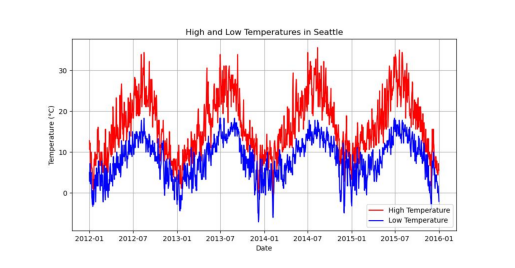

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

The provided figure shows a time series plot of high and low temperatures in Seattle. Here are a few suggestions for improving the plot:

1. **Resolution and Clarity**: The image appears to have low resolution, which makes the text and lines a bit blurry. Increasing the resolution would enhance clarity.

2. **Color Contrast**: The colors chosen for high and low temperatures (red and blue) are good for contrast, but ensuring that they are distinguishable by all audiences, including those with color vision deficiencies, can be useful. Consider using colorblind-friendly palettes.

3. **Line Thickness**: The lines look slightly thick, which can cause them to blur together when they cross or when viewed at smaller sizes. Thinner lines might provide better clarity.

4. **Smoothing**: The data appears to be quite noisy. If the aim is to show trend

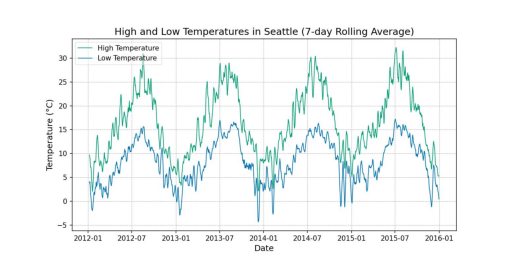

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I'm sorry, but as an AI developed by OpenAI, I don't have the capability to view images directly or interpret visual feedback. My previous response provided an updated script intended to address the initial feedback points you provided.

If there are specific aspects of the figure from the `result.jpg` file that you would like to further adjust, please provide clear textual feedback about what specific improvements you would like to see. For example, you can ask for:

- Adjustments to the graphical elements such as line style or markers.
- Changes to the axes or grid to improve visibility.
- Modifications to the smoothing function 

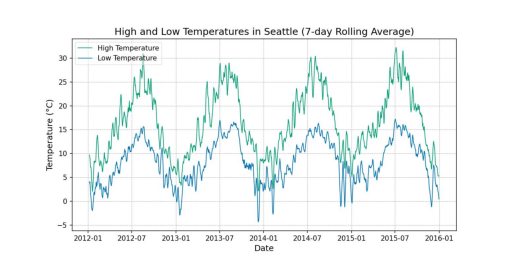

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [7]:
creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0, code_execution_config={"use_docker": False}
)

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""",
)

In [8]:
if os.path.exists("result.jpg"):
    os.remove("result.jpg")  # clean up

## Group Chat Example with Multimodal Agent

In [9]:
agent1 = MultimodalConversableAgent(
    name="image-explainer-1",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is poetic and engaging.",
)
agent2 = MultimodalConversableAgent(
    name="image-explainer-2",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is factual and to the point.",
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Ask both image explainer 1 and 2 for their description.",
    human_input_mode="TERMINATE",  # Try between ALWAYS, NEVER, and TERMINATE
    max_consecutive_auto_reply=10,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# We set max_round to 5
groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=5)
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_llm_config)

user_proxy.initiate_chat(
    group_chat_manager,
    message="""Describe the image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to chat_manager):

Describe the image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer-1 (to chat_manager):

In the soft embrace of a quiet room, a curly-haired sentinel of joy rests upon the floor—a puppy, with fur the color of sunlit autumn leaves. Its innocent eyes, deep and dark as a twilight sky, gaze into the world with wonder and gentle curiosity. Adorned with a collar that boasts a bright, mosaic-like pattern, the young canine wears a name tag shaped like a heart, whispering the promise of unconditional love and companionship. In the background, a pair of black boots stands sentinel, hinting at the return of a beloved owner, while the puppy waits, the embodiment of warmth and affection in an often too brisk world.

-----------------------------------------------

In [10]:
agent1._oai_messages

defaultdict(list,
            {<autogen.agentchat.groupchat.GroupChatManager at 0x7f690545b820>: [{'content': [{'type': 'text',
                 'text': 'Describe the image:\n                        '},
                {'type': 'image_url',
                 'image_url': {'url': <PIL.Image.Image image mode=RGB size=1920x1080>}},
                {'type': 'text', 'text': '.'}],
               'name': 'User_proxy',
               'role': 'user'},
              {'content': [{'type': 'text',
                 'text': 'In the soft embrace of a quiet room, a curly-haired sentinel of joy rests upon the floor—a puppy, with fur the color of sunlit autumn leaves. Its innocent eyes, deep and dark as a twilight sky, gaze into the world with wonder and gentle curiosity. Adorned with a collar that boasts a bright, mosaic-like pattern, the young canine wears a name tag shaped like a heart, whispering the promise of unconditional love and companionship. In the background, a pair of black boots stands sen